In [15]:
import numpy as np 
import pandas as pd
import scipy
import utils

TS = 48 # Time steps
UID = 25 # Householder ID
MBC = 44. # Max capacitiy of Battery
horizon = 48 # TS

data_test, df_date = utils.load_data('AusGrid_preprocess.csv', [UID], TS)
load = data_test[0]['GC'].to_numpy()
pvgn = data_test[0]['GG'].to_numpy()*4.05


u : current soc
x0 : grid status(import/export power)
x1 : previous soc of battery (10% to 95%)
x2 : charging/discharging power for battery

In [16]:
def batt_model(u, x, pv, ld):
    # print('batt_model', u, x, pv, ld)
    x_next = np.zeros(3)
    x_next[0] = ld - pv + (u - x[1])
    x_next[1] = u
    x_next[2] = u - x[1] # current soc - previous soc 

    return x_next

In [17]:
import math 
def cal_sc(pv, ld, expw):
    return (pv - expw)/pv if pv > 0 else 0

def cal_ss(pv, ld, impw):
    return (ld - impw)/ld if ld > 0 else 0
    
def cost(u, x, pos, pv, ld):
    wt = 0.5
    cost_val = 0.0
    expw = 0.0
    impw = 0.0
    tpv = 0.0
    tld = 0.0
    mlt = len(pv)
    for i in range(horizon):
        x =  batt_model(u[i], x, pv[(pos+i)%mlt], ld[(pos+i)%mlt])
        expw += abs(x[0]) if x[0] < 0 else 0
        impw += abs(x[0]) if x[0] > 0 else 0
        tpv += pv[(pos+i)%mlt]
        tld += ld[(pos+i)%mlt]
        # cost_val += abs(x[0])

    sc = cal_sc(tpv, tld, expw)
    ss = cal_ss(tpv, tld, impw)
    cost_val -= wt*sc + (1-wt)*ss
    return cost_val

In [18]:
def constraint_0(u, x, pos, pv, ld):
    lpv = len(pv)
    xnext =  batt_model(u[0], x, pv[(pos)%lpv], ld[(pos)%lpv])
    return ld[(pos)%lpv] - pv[(pos)%lpv] + (u[0] - x[1]) - xnext[0]

def constraint_1(u, x, pos, pv, ld):
    lpv = len(pv)
    return (pv[(pos)%lpv] -  ld[(pos)%lpv]) - u[0]

def constraint_2(u, x, pos, pv, ld):
    lpv = len(pv)
    return (ld[(pos)%lpv] - pv[(pos)%lpv]) + u[0]


In [19]:


LDT = len(load)
BCMIN = 0.10
BCMAX = 0.95
x0 = np.array([0, MBC*BCMIN, 0])
u0 = np.zeros(horizon)

u = []
x = []
for i in range(LDT):
    arguments = (x0, i, pvgn, load)
    constraints = ({'type': 'eq', "fun": constraint_0, 'args':arguments})
    # , 
    #                {'type': 'ineq', "fun": constraint_1, 'args':arguments},
    #                {'type': 'ineq', "fun": constraint_2, 'args':arguments})
    
    bnds = ((MBC*BCMIN, MBC*BCMAX),)
    options = {'disp':False, 'maxiter':5000}
    # res = scipy.optimize.minimize(cost, u0, bounds=bnds, args=arguments, constraints=constraints)
    res = scipy.optimize.minimize(cost, u0, bounds=bnds, args=arguments, constraints=None, method="SLSQP", options=options)
    u0 = res.x.copy()

    x0 = batt_model(u0[0], x0, pvgn[(i)%LDT], load[(i)%LDT])
    
    u.append(u0[0])
    x.append(x0)
x = np.array(x)
print(res.x)
print(res.success)
print(res.message)

/Users/jwheo/Projects/etc_project/.venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


[6.95445534 7.11027699 7.13127016 7.43861774 7.50422447 7.50941039
 7.49079874 7.47129368 7.56987156 7.64734614 7.68434287 7.88697425
 7.98230222 7.88340738 7.78904447 7.78586689 7.77495052 6.97770714
 4.43793085 4.40542555 4.71226498 5.04726439 4.92694711 4.83369202
 5.15074154 5.62023414 6.68627825 6.83299988 7.15475011 7.28942565
 8.13833798 9.1026887  9.71414479 9.83676033 9.85945015 9.87067478
 9.92843589 9.88116592 9.77939478 9.67822534 9.57459595 7.81069088
 5.6365233  5.24275457 5.0298211  4.79398125 4.61096406 4.4       ]
True
Optimization terminated successfully


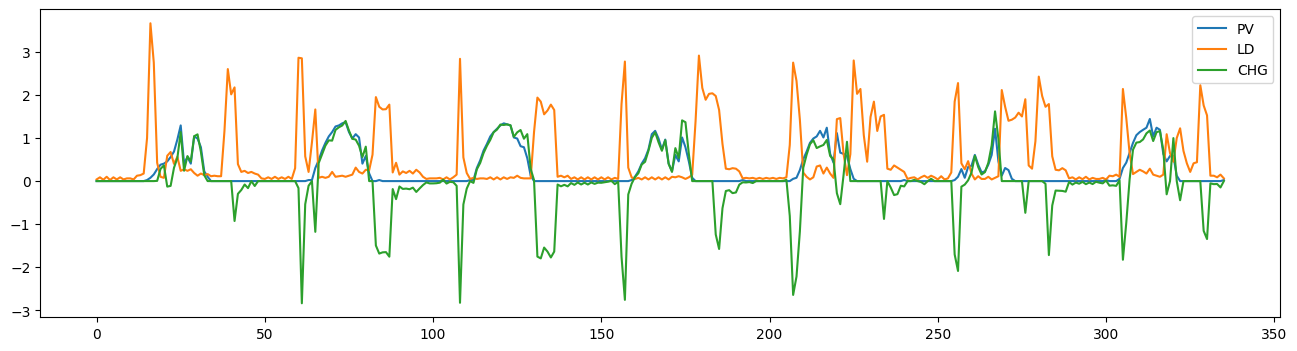

In [20]:
import matplotlib.pyplot as plt 

start = TS*0
end = start+TS*7
fig = plt.figure(figsize=(16, 4))
# plt.plot(x[start:end, 0], label='GRD')
plt.plot(pvgn[start:end], label='PV')
plt.plot(load[start:end], label='LD')
plt.plot(x[start:end, 2], label='CHG')
# plt.plot(u[start:end], label='SOC')
plt.legend()


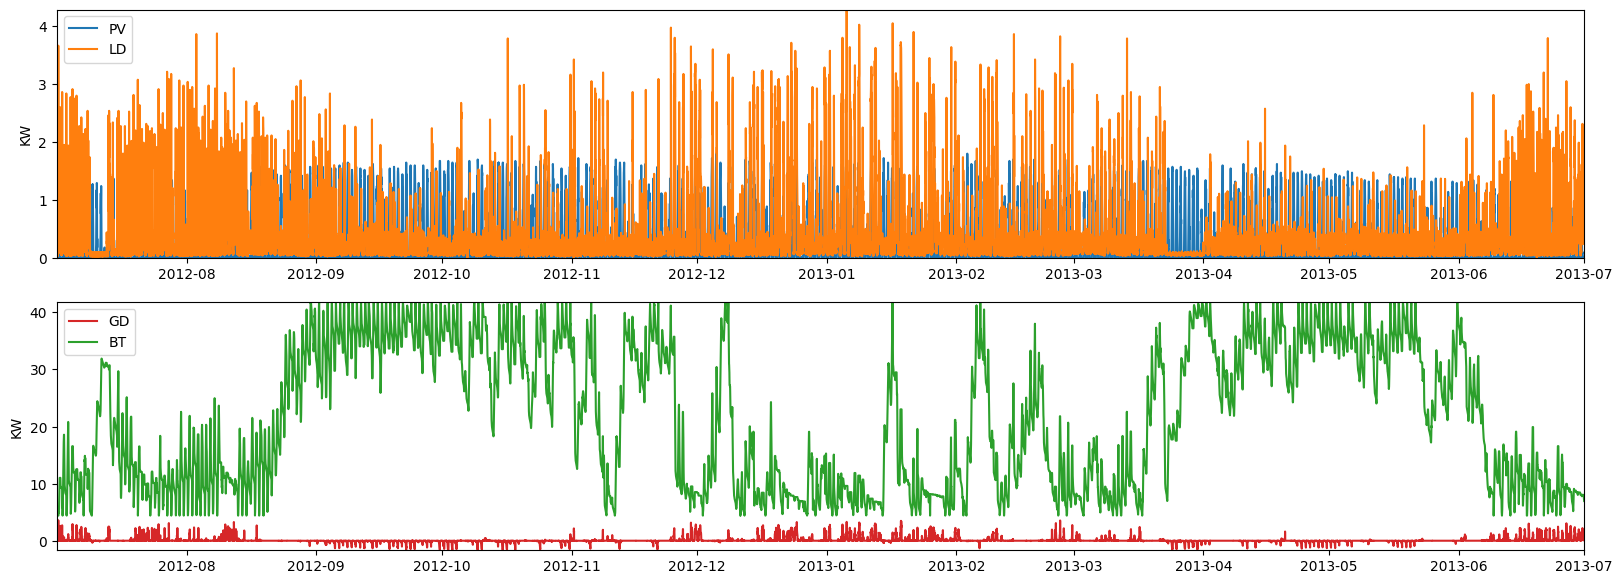

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
plt.rcParams["font.size"] = "10"
fig.tight_layout()

axes[0].plot(df_date.values, pvgn, label='PV', color='#1f77b4')
axes[0].plot(df_date.values, load, label='LD', color='#ff7f0e')
axes[0].legend(loc='upper left')
axes[0].set_ylabel('KW')
axes[0].grid(False)
axes[0].margins(0,0)

axes[1].plot(df_date.values, x[:, 0], label='GD', color='#d62728')
axes[1].plot(df_date.values, u, label='BT', color='#2ca02c')
axes[1].legend(loc='upper left')
axes[1].set_ylabel('KW')
axes[1].grid(False)
axes[1].margins(0,0)

In [22]:
Egen = pvgn.sum()
print(Egen, 'KW')
Eload = load.sum()
print(Eload, 'KW')
GDimport = x[:, 0][x[:, 0]>0].sum()
print(GDimport)
GDexport = x[:, 0][x[:, 0]<0].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Eload - GDimport)/Eload
print('SC :', SC)
print('SS :', SS)

5516.3187 KW
6793.392 KW
2008.5489709968733
-728.921215658914
SC : 0.8678609313020813
SS : 0.7043378372693827


In [23]:
df_out = pd.DataFrame()
df_out['Date'] = df_date
df_out['PV'] = pvgn
df_out['LD'] = load
df_out['GD'] = x[:,0]
df_out['BT'] = x[:,1]
df_out['CH'] = x[:,2]

df_out.to_csv('mpc_hzn.csv')
df_out.set_index('Date', inplace=True)

(-5.0, 5.0)

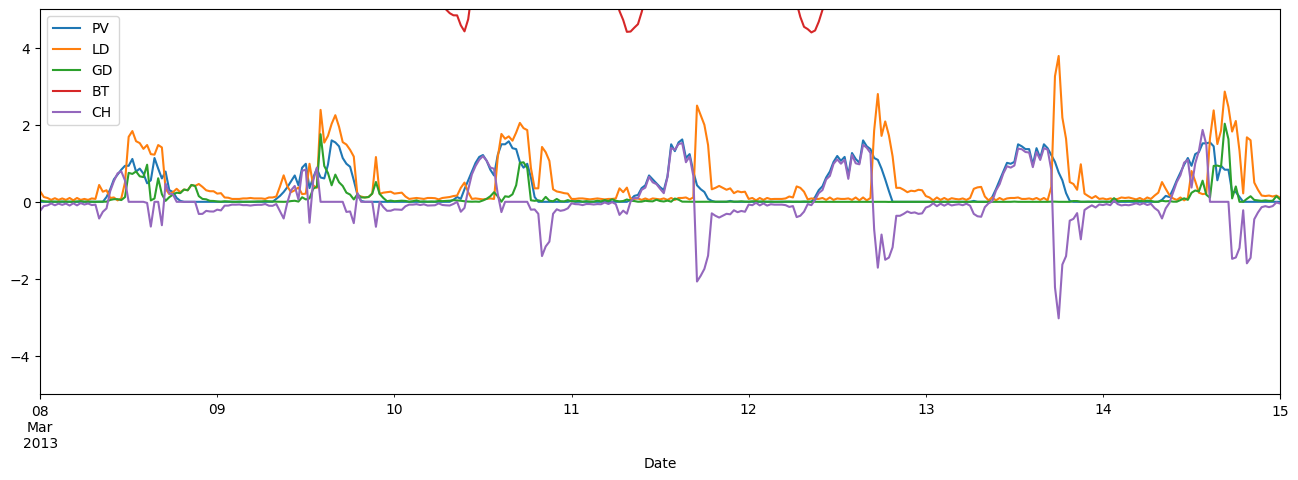

In [24]:
ax = df_out.plot(figsize=(16,5))
ax.set_xlim(pd.Timestamp('2013-03-08 00:00:00'), pd.Timestamp('2013-03-15 00:00:00'))
ax.set_ylim(-5, 5)